### Picking a Dataset
- should be toy/standard dataset(MNIST, Titanic, CIFAR10)
toy -> for beginers/learning
standard -> Good for portfolio
- should be large enough
- should have enough variety
- it should be possible to build a good model
- should not be too large(>5GB) -> may run into memory issues, so not a good experiance.
  - Exception: pick a 10% or 1% sample

### Dataset Candidates
1. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia -> only two classes and made by many beginners so not good for portfolio.
2. https://www.kaggle.com/datasets/moltean/fruits -> good for portfolio have good varietes and usability.
3. https://www.kaggle.com/datasets/alxmamaev/flowers-recognition -> good for portfolio, 5 catergories
4. https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria -> very good dataset, not so common image classification task.
5. https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time -> very good dataset. have multiple classes with non uniform no of images.
If we use GANs for the above dataset it will become a very good project for portfolio.
6. https://www.kaggle.com/datasets/grassknoted/asl-alphabet -> cool application.
7. https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
8. https://www.kaggle.com/datasets/jessicali9530/celeba-dataset -> Let's try this.

**Its always good to have similar datasets if we want change the dataset so we can**

Now we will be using these datasets.

colabA - https://www.kaggle.com/datasets/jessicali9530/celeba-dataset 

Flower recognition - https://www.kaggle.com/datasets/alxmamaev/flowers-recognition 

### Download the dataset

#### Steps todo
1. Pick a dataset.
2. Download the dataset 
3. Import the dataset using pytorch.
4. Explore the dataset.
5. prepare the dataset for training.

In [1]:
# downloading the dataset
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'
od.download(dataset_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [4]:
data_dir = './flowers-recognition/flowers/'

In [5]:
import os

In [6]:
os.listdir(data_dir)

['daisy', 'rose', 'dandelion', 'sunflower', 'tulip']

In [7]:
# for removing the unnecessary directories.
# import shutil
# shutil.rmtree(data_dir + '/flowers')

In [8]:
for cls in os.listdir(data_dir):
  print(cls, len(os.listdir(data_dir + "/" + cls)))

daisy 764
rose 784
dandelion 1052
sunflower 733
tulip 984


### Import the dataset into pytorch
import the ImageFolder class from torchvision

In [9]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir)
dataset

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: ./flowers-recognition/flowers/

In [10]:
len(dataset)

4317

In [11]:
dataset[3433] # Have the pil image and class which it belongs to

(<PIL.Image.Image image mode=RGB size=500x333 at 0x7F7A49E04580>, 4)

In [12]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

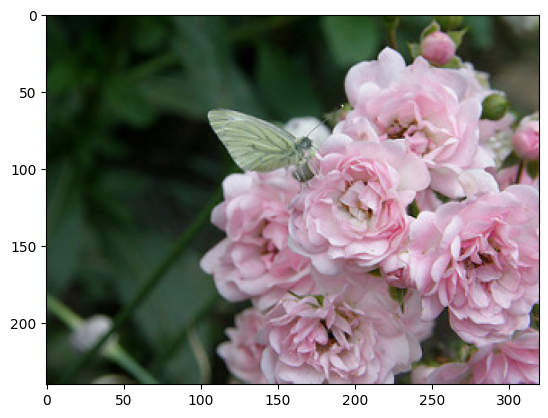

In [14]:
image, label = dataset[2424]
plt.imshow(image)
plt.show()

In [15]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                  tt.RandomCrop(64),
                                  tt.ToTensor()]))

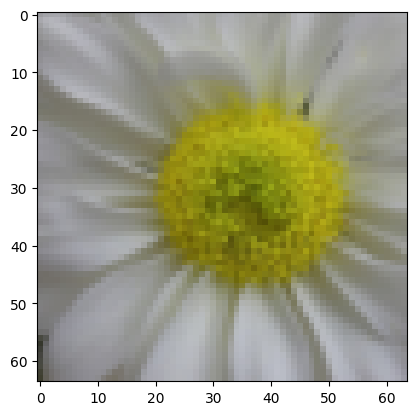

In [16]:
image, label = dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [17]:
val_pct = 0.1
val_size = int(val_pct*len(dataset))
train_size = len(dataset) - val_size
train_size, val_size

(3886, 431)

In [18]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3886, 431)

In [19]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

val_dl = DataLoader(train_ds,
                    batch_size,
                    shuffle=True,
                    num_workers=2,
                    pin_memory=True)

In [20]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

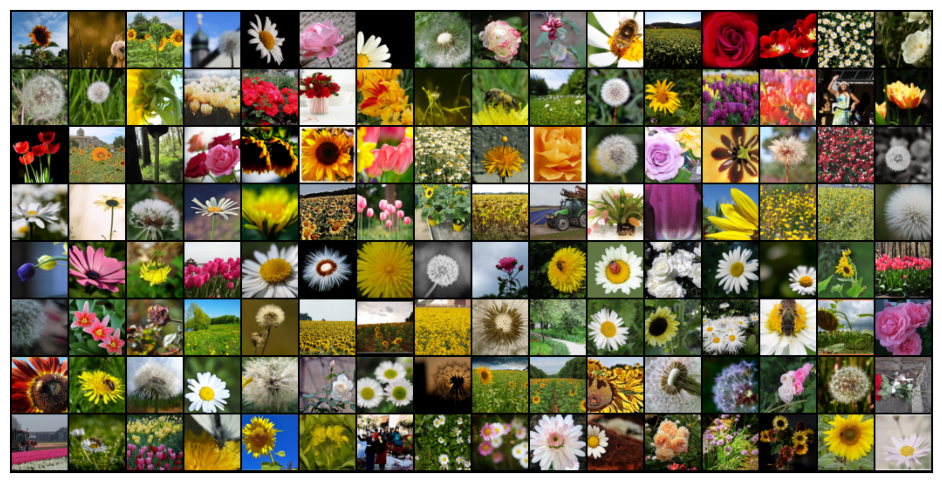

In [21]:
show_batch(train_dl)

## Utility Functions and Classes

In [22]:
import torch

def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  "Move tensor to gpu"
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
      self.dl = dl
      self.device = device
    
    def __iter__(self):
      for b in self.dl:
        yield to_device(b, self.device)
      
    def __len__(self):
      return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
img, label = dataset[0]
img.shape, label

(torch.Size([3, 64, 64]), 0)

In [25]:
img.device

device(type='cpu')

In [26]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model and Training Utilities

In [28]:
import torch.nn as nn

class ImageClassificationBase(nn.Module):
  def training_batch(self, batch):
    images, labels = batch
    out = self(images)                  # predict the output
    loss = F.cross_entropy(out, labels) # calculate loss
    return loss
  
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss':loss.detach(), 'val_acc':acc}

  def validation_epoch_end(self, batches):
    batch_losses = [x['val_loss'] for x in batches]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in batches]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epochs:[{epoch}], train loss:{:.4f}, val loss:{.4f}, val acc:{.4f}}".format(epoch, 
                                                                                       result['train_loss'],
                                                                                       result['val_loss'],
                                                                                       result['val_acc']))

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(outputs==preds).item/len(preds))

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
  """Evaluate's model's performance on the validation set"""
  model.eval()
  outputs = [model.validation_step[batch] for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameter(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

## Model

In [30]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    # input: 128 x 3 x 64 x 64
    self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
    self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
    self.resl = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                              conv_block(128, 128)) # 128 x 128 x 32 x 32

    self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
    self.conv4 = conv_block(256, 512, pool=True) # 128 x 256 x 16 x 16
    self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                              conv_block(512, 512)) # 128 x 512 x 8 x 8

    self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                    nn.Flatten(), # 128 x 512
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(xb)
    out = self.res1(out) + out
    out = self.conv3(xb)
    out = self.conv4(xb)
    out = self.res2(out) + out
    out = self.classifier(out)

In [31]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (resl): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [32]:
model.conv1[0].weight.device

device(type='cuda', index=0)

### Pass one batch of input tensor through the model

In [33]:
for batch in train_dl:
  images, labels = batch
  print("images.shape : ", images.shape)
  print("images.device: ", images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  print(preds)
  break

images.shape :  torch.Size([128, 3, 64, 64])
images.device:  cuda:0


RuntimeError: ignored